In [ ]:
import tensorflow as tf
import os
import random
# import the libraries as shown below
import numpy.random
from skimage.transform import resize
import numpy as np
import pandas as pds

import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
# from tensorflow.keras.applications.vgg19 import preprocess_input
# from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
# from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

from tensorflow.keras.models import Sequential
from keras.utils import plot_model

from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input, Concatenate, Conv2D, Multiply

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/gdrive')

# Path to the folder in Google Drive
train_path = '/content/gdrive/MyDrive/RESEARCH/archive (4).zip (Unzipped Files)/train'
num_of_classes =5

# Check if the folder exists
if os.path.exists(train_path):
    # List all files and folders in the specified folder
    file_list = os.listdir(train_path)

    for file_name in file_list:
        file_path = os.path.join(train_path, file_name)
        if os.path.isdir(file_path):
            print(f"Folder: {file_name}")
        else:
            print(f"File: {file_name}")
else:
    print("Folder not found.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Folder: 0
Folder: 1
Folder: 2
Folder: 3
Folder: 4


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/gdrive')

# Path to the folder in Google Drive
test_path = '/content/gdrive/MyDrive/RESEARCH/archive (4).zip (Unzipped Files)/train'

# Check if the folder exists
if os.path.exists(test_path):
    # List all files and folders in the specified folder
    file_list = os.listdir(test_path)

    for file_name in file_list:
        file_path = os.path.join(test_path, file_name)
        if os.path.isdir(file_path):
            print(f"Folder: {file_name}")
        else:
            print(f"File: {file_name}")
else:
    print("Folder not found.")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Folder: 0
Folder: 1
Folder: 2
Folder: 3
Folder: 4


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
# Define the path to the dataset
#dataset_path = test_path_new

# Define the batch size and image size
batch_size = 32
img_height = 256
img_width = 256

# Define the data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomCrop(224, 224),
    # tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
    # tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

Testing_data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
    ])

# Create a dataset from the directory of images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path, #dataset_path,
    #validation_split=0.3,
    #subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)



# Split the dataset into training and testing sets
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
     test_path, #dataset_path,
    #validation_split=0.3,
    #subset="validation",
    seed=123,
    #image_size=(img_height, img_width),
    batch_size=batch_size)

# Define the number of classes
num_classes = len(train_ds.class_names)
print(train_ds.class_names)
# Configure the datasets for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 5778 files belonging to 5 classes.
Found 5778 files belonging to 5 classes.
['0', '1', '2', '3', '4']


In [ ]:
# Apply the data augmentation pipeline to the dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
test_ds = test_ds.map(lambda x, y: (Testing_data_augmentation(x), y))

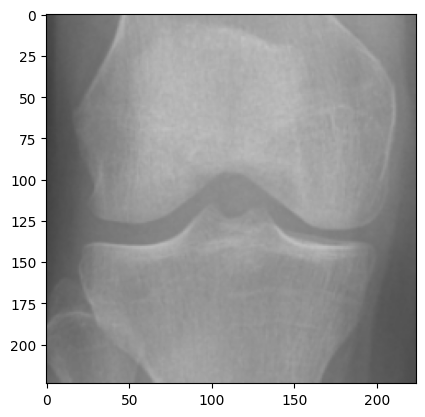

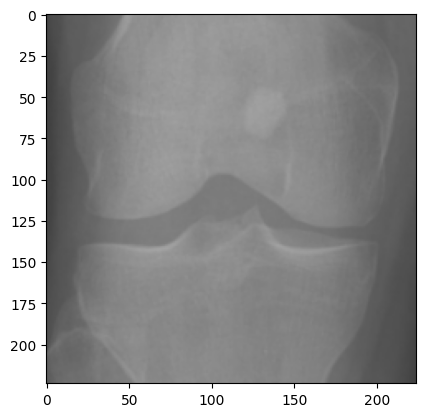

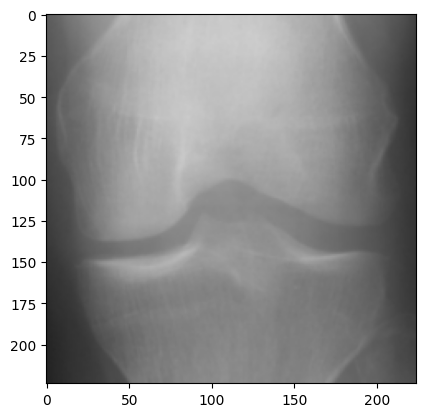

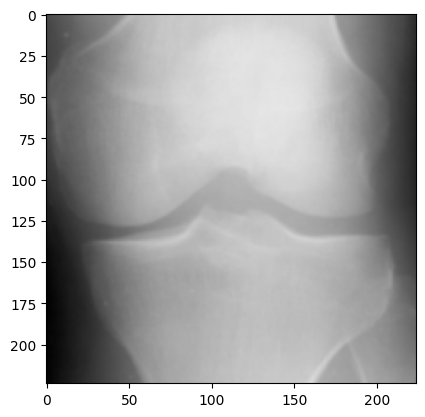

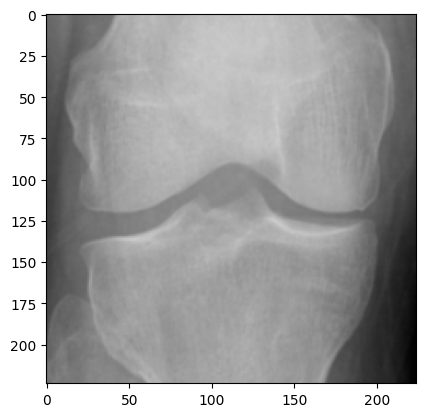

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

for images, labels in test_ds.take(1):
    for i in range(5):
        image = images[i].numpy().astype(np.uint8)
        image = Image.fromarray(image)
        plt.imshow(image)
        plt.show()


16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

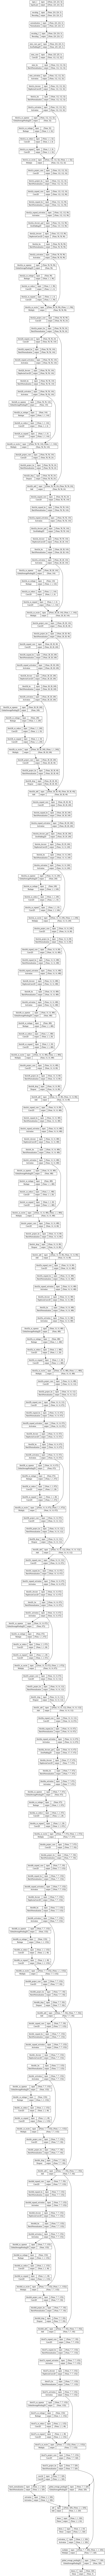

In [ ]:

from tensorflow.keras.layers import Activation,Add


def channel_attention_module(x):
    batch, _, _, channel = x.shape

    # Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)

    # Global Max Pooling
    x2 = Conv2D(320, kernel_size=7,activation="relu")(x)
    x2 = tf.keras.layers.BatchNormalization(scale=False, axis=3)(x2)
    x2= tf.keras.layers.Activation('relu')(x2)
    # Add both the features and pass through sigmoid
    l = Add()([x1,x2])
    l= Dense(64, activation="relu", use_bias=False)(l)
    l = Dense(320)(l)
    l = Activation("softmax")(l)
    l = Multiply()([x, l])

    return l


def attention(x):
    x = channel_attention_module(x)
    return x

def efficientnet_attention(input_shape=(224,224, 3), classes=5):
    # Load EfficientNetB0 model
    net1 = keras.applications.EfficientNetB0(include_top = False , input_shape = (224,224,3),weights='imagenet')

    # Apply attention to the output of the base model
    x = attention(net1.get_layer('block7a_project_bn').output)

    # Add a global average pooling layer and a dense output layer
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=net1.input, outputs=x)

    return model

if __name__ == "__main__":
    input_shape = (224, 224, 3)
    classes = 5
    model = efficientnet_attention(input_shape, classes)
    model.summary()



tf.keras.utils.plot_model(model, show_shapes=True, to_file='CNN_block.png')

In [ ]:
# Compile the  model

learning_rate = 0.003
num_epochs = 50


#decay_rate = learning_rate / 10;
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=['accuracy'])

# Print the summary of the fusion model
# fusion_model.summary()(

'''
ES = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.01,
    verbose=1
)
'''
# Cache and prefetch the test dataset for better performance
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Train the model for the specified number of epochs
history = model.fit(train_ds, epochs=num_epochs, validation_data=test_ds, verbose=1,shuffle=True)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print('Test accuracy:', test_acc)


Epoch 1/50
181/181 [==============================] - 1195s 435ms/step - loss: 1.4345 - accuracy: 0.3887 - val_loss: 1.9537 - val_accuracy: 0.3996
Epoch 2/50
181/181 [==============================] - 60s 331ms/step - loss: 1.3398 - accuracy: 0.4109 - val_loss: 3.9920 - val_accuracy: 0.3844
Epoch 3/50
181/181 [==============================] - 60s 330ms/step - loss: 1.3273 - accuracy: 0.4289 - val_loss: 1.6314 - val_accuracy: 0.3844
Epoch 4/50
181/181 [==============================] - 59s 329ms/step - loss: 1.2226 - accuracy: 0.4742 - val_loss: 1.5732 - val_accuracy: 0.3955
Epoch 5/50
181/181 [==============================] - 60s 329ms/step - loss: 1.2777 - accuracy: 0.4391 - val_loss: 1.3180 - val_accuracy: 0.4611
Epoch 6/50
181/181 [==============================] - 60s 330ms/step - loss: 1.1613 - accuracy: 0.4907 - val_loss: 1.3604 - val_accuracy: 0.4500
Epoch 7/50
181/181 [==============================] - 59s 329ms/step - loss: 1.1360 - accuracy: 0.5111 - val_loss: 1.1908 - val_

In [ ]:
# Compile the fusion model

learning_rate = 0.0003
num_epochs = 20


#decay_rate = learning_rate / 10;
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=['accuracy'])

# Print the summary of the fusion model
# fusion_model.summary()

'''
ES = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.01,
    verbose=1
)
'''
# Cache and prefetch the test dataset for better performance
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Train the model for the specified number of epochs
history = model.fit(train_ds, epochs=num_epochs, validation_data=test_ds, verbose=1,shuffle=True)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print('Test accuracy:', test_acc)

Epoch 1/20
181/181 [==============================] - 71s 340ms/step - loss: 0.8116 - accuracy: 0.6577 - val_loss: 0.7921 - val_accuracy: 0.6681
Epoch 2/20
181/181 [==============================] - 59s 326ms/step - loss: 0.7886 - accuracy: 0.6684 - val_loss: 0.7873 - val_accuracy: 0.6687
Epoch 3/20
181/181 [==============================] - 60s 329ms/step - loss: 0.7833 - accuracy: 0.6700 - val_loss: 0.7793 - val_accuracy: 0.6734
Epoch 4/20
181/181 [==============================] - 60s 330ms/step - loss: 0.7757 - accuracy: 0.6764 - val_loss: 0.7785 - val_accuracy: 0.6743
Epoch 5/20
181/181 [==============================] - 60s 331ms/step - loss: 0.7723 - accuracy: 0.6722 - val_loss: 0.7830 - val_accuracy: 0.6760
Epoch 6/20
181/181 [==============================] - 60s 330ms/step - loss: 0.7742 - accuracy: 0.6741 - val_loss: 0.7575 - val_accuracy: 0.6843
Epoch 7/20
181/181 [==============================] - 59s 328ms/step - loss: 0.7657 - accuracy: 0.6736 - val_loss: 0.7511 - val_ac

In [ ]:


# Predict the test labels
test_labels = []
predicted_labels = []
for images, labels in test_ds:
    predicted_labels_batch = model.predict(images)
    predicted_labels_batch = tf.argmax(predicted_labels_batch, axis=1)
    test_labels.append(labels.numpy())
    predicted_labels.append(predicted_labels_batch.numpy())

test_labels = np.concatenate(test_labels)
predicted_labels = np.concatenate(predicted_labels)




1/1 [==============================] - 1s 1s/step


Confusion matrix:


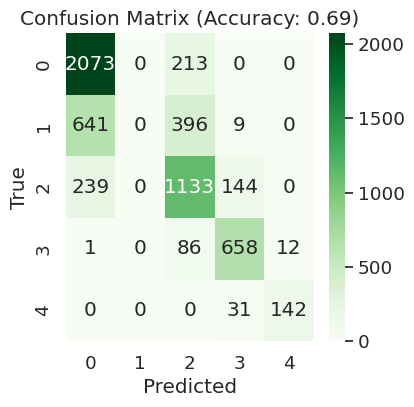

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# Compute confusion matrix

confusion_mat = confusion_matrix(test_labels, predicted_labels)
print('Confusion matrix:')

class_labels =['0', '1','2','3','4']
plt.figure(figsize=(4,4))
sns.set(font_scale=1.2)

sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
# Calculate accuracy (optional)
accuracy = accuracy_score(test_labels, predicted_labels)
# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2f})')

# Show the plot
plt.show()

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['0', '1','2','3','4']
print(classification_report(test_labels, predicted_labels, target_names=target_names))


Classification Report
              precision    recall  f1-score   support

           0       0.70      0.91      0.79      2286
           1       0.00      0.00      0.00      1046
           2       0.62      0.75      0.68      1516
           3       0.78      0.87      0.82       757
           4       0.92      0.82      0.87       173

    accuracy                           0.69      5778
   macro avg       0.61      0.67      0.63      5778
weighted avg       0.57      0.69      0.62      5778



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
